In [ ]:
!python -m pip install --user setfit --upgrade
!python -m pip install --user setfit[optuna]
!python -m pip install --user optuna==3.1.0
!python -m pip install --user huggingface_hub

In [5]:
import pandas as pd
import numpy as np
import math

In [6]:
import setfit
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss, ContrastiveLoss, SoftmaxLoss, TripletLoss


In [7]:

from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

### Ensure that the data is loaded with your desired number of classes and that these classes are included in the class list. Also, set the multi_label variable to True if you want to enable multi-label classification.

In [ ]:
multi_label = True

classes = ['informing statement',
 'challenge',
 'accusation',
 'rejection',
 'appreciation',
 'request',
 'question',
#  'evaluation',
#  'proposal',
 'acceptance',
#  'denial',
#  'admission',
 'apology']
num_classes = len(classes)

In [9]:
def get_multi_label_labels(row):
    row_labels = []
    row_labels.append(row['primary tag'])
    if str(row['secondary tag']) != 'nan':
        row_labels.append(row['secondary tag'])
    if str(row['tertiary']) != 'nan':
        row_labels.append(row['tertiary'])
    return row_labels

def create_multi_label_dataset(data):
    new_data = []
    for i, row in data.iterrows():
        new_row = dict()
        new_row['text'] = row['Text']
        labels = get_multi_label_labels(row)
        for j in classes:
            if j in labels:
                new_row[j] = 1
            else:
                new_row[j] = 0
        new_data.append(new_row)
    return pd.DataFrame(new_data)
 

In [10]:
train = pd.read_csv('new_splited_data/train_9classes.csv')
if not multi_label:
    train['Label'] = train['primary tag'].apply(lambda x: classes.index(x))
    train_df = train[['Text', 'Label']]
    train_df.columns = ['text', 'label']
else:
    train_df = create_multi_label_dataset(train)

test1 = pd.read_csv('new_splited_data/test_9classes.csv')
if not multi_label:
    test1['Label'] = test1['primary tag'].apply(lambda x: classes.index(x))
    test_df = test1[['Text', 'Label']]
    test_df.columns = ['text', 'label']
else:
    test_df = create_multi_label_dataset(test1)


dev = pd.read_csv('new_splited_data/dev_9classes.csv')
if not multi_label:
    dev['Label'] = dev['primary tag'].apply(lambda x: classes.index(x))
    dev_df = dev[['Text', 'Label']]
    dev_df.columns = ['text', 'label']
else:
    dev_df = create_multi_label_dataset(dev)

train_dev_df = pd.concat((train_df, dev_df))

train_df.shape, dev_df.shape, test_df.shape

((406, 10), (135, 10), (135, 10), (101, 10))

## Preparing data for SetFit

In [11]:

from datasets import Dataset

train_ds = Dataset.from_dict(train_df)
dev_ds = Dataset.from_dict(dev_df)
test_ds = Dataset.from_dict(test_df)
train_dev_ds = Dataset.from_dict(train_dev_df)


In [13]:
def encode_labels(record):
    return {"label": [record[feature] for feature in classes]}

if multi_label:
    train_ds = train_ds.map(encode_labels)
    dev_ds = dev_ds.map(encode_labels)
    test_ds = test_ds.map(encode_labels)
    train_dev_ds = train_dev_ds.map(encode_labels)
    
train_ds

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/541 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'informing statement', 'challenge', 'accusation', 'rejection', 'appreciation', 'request', 'question', 'acceptance', 'apology', 'label'],
    num_rows: 406
})

## Loading the model 

### Ensure that you configure the settings correctly!

In [15]:
# Load a SetFit model from Hub 
pretrained_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2' #'sentence-transformers/paraphrase-albert-small-v2'
if multi_label:
    model = SetFitModel.from_pretrained(pretrained_model_name, multi_target_strategy="one-vs-rest")
else:
    params = {'max_iter': 273, 'solver': 'liblinear'}
    model = SetFitModel.from_pretrained(pretrained_model_name, **params)
   

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [16]:
def f1_score_weigted(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')


In [47]:

config = {
    'learning_rate': 1.8042269379987103e-06, 'num_epochs': 2, 'batch_size': 2, 'seed': 36, 'num_iterations': 14
}


## Training starts!


In [49]:

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dev_ds,
    eval_dataset=test_ds,
    loss_class=CosineSimilarityLoss,
    metric= f1_score_weigted,
    **config,
)
# Push model to the Hub
# trainer.push_to_hub("my-awesome-setfit-model")

# Train and evaluate
trainer.train()
metric = trainer.evaluate()
metric

Generating Training Pairs:   0%|          | 0/14 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 20398
  Num epochs = 2
  Total optimization steps = 20398
  Total train batch size = 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10199 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10199 [00:00<?, ?it/s]

***** Running evaluation *****


0.6484238035786637

## Evaluation starts!

In [50]:
# model = new_model
# Run inference
preds = model.predict(test_df['text']).numpy()
preds.shape

(135, 9)

In [51]:
# probs = model.predict_proba(test_df['text'].values).numpy()
# probs = np.max(probs, axis=1)
# probs.shape

In [52]:

if not multi_label:
    # preds_labels = [classes[i] for i in preds]
    y_true = test_df['label']
    y_pred = preds
else:
    y_true = test_df.drop(columns=['text']).values
    y_pred = preds
y_true.shape, y_pred.shape

((135, 9), (135, 9))

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

#### Confusion Matrix


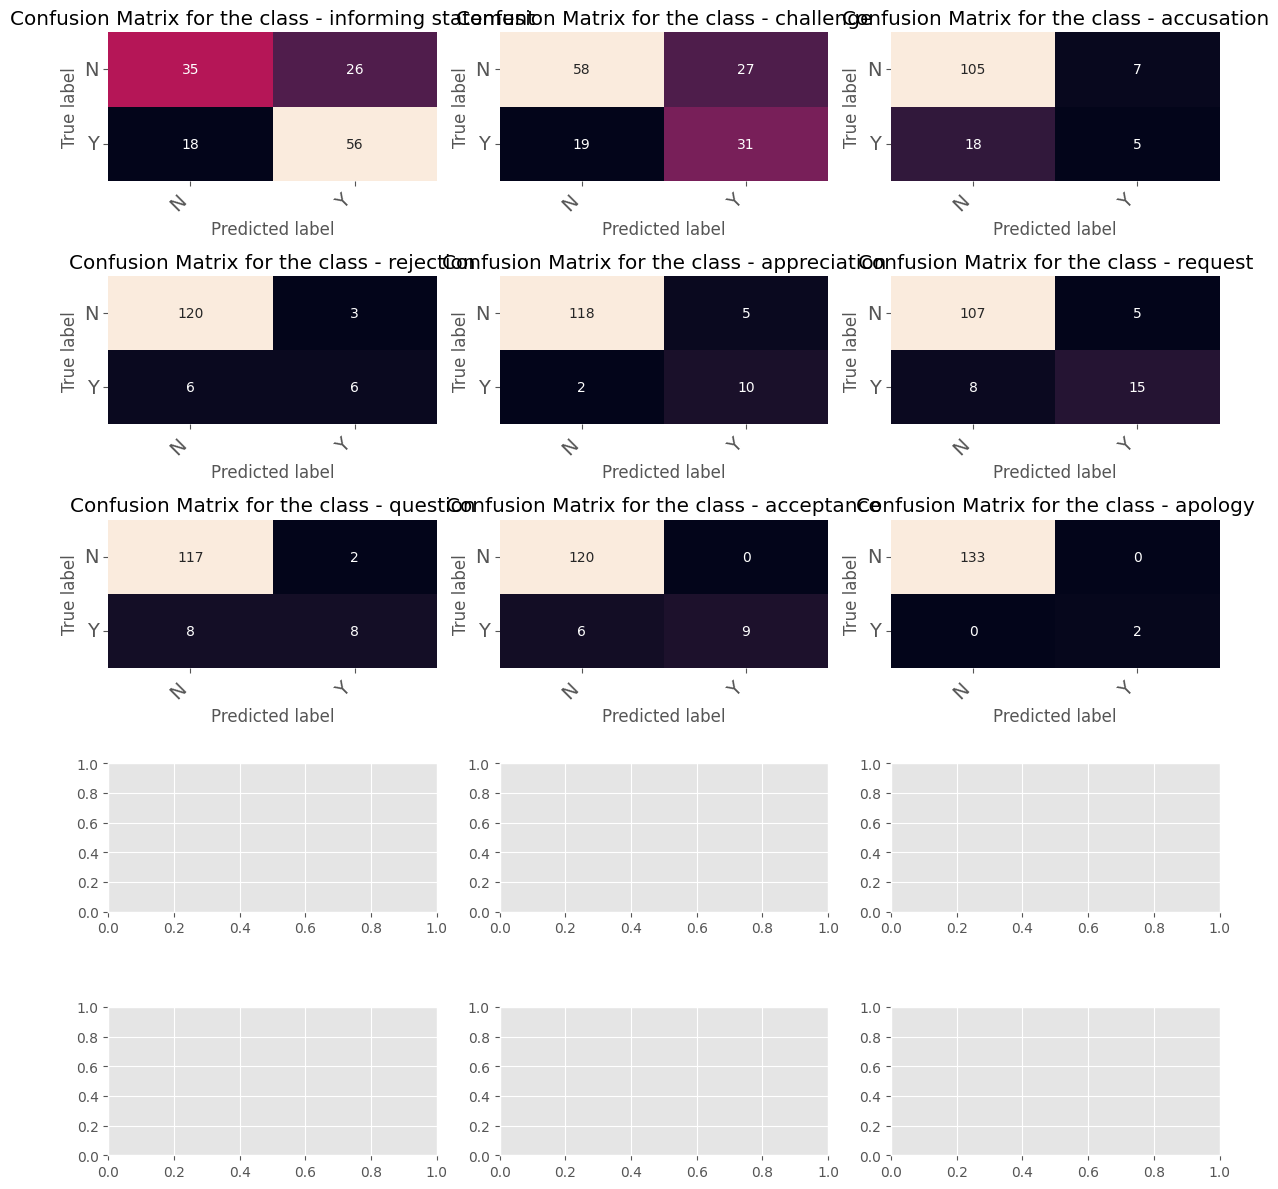

<Figure size 640x480 with 0 Axes>

In [54]:

if not multi_label:

    cm = confusion_matrix(y_true, y_pred)#, normalize='pred')
    df_cm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)
else:
    cm = multilabel_confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(5, 3, figsize=(12, 12))
    
    for axes, cfs_matrix, label in zip(ax.flatten(), cm, classes):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

    fig.tight_layout()
    plt.show()   

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

                     precision    recall  f1-score   support

informing statement       0.68      0.76      0.72        74
          challenge       0.53      0.62      0.57        50
         accusation       0.42      0.22      0.29        23
          rejection       0.67      0.50      0.57        12
       appreciation       0.67      0.83      0.74        12
            request       0.75      0.65      0.70        23
           question       0.80      0.50      0.62        16
         acceptance       1.00      0.60      0.75        15
            apology       1.00      1.00      1.00         2

          micro avg       0.65      0.63      0.64       227
          macro avg       0.72      0.63      0.66       227
       weighted avg       0.66      0.63      0.63       227
        samples avg       0.69      0.65      0.64       227



In [56]:
micro_f1_score = f1_score(y_true, y_pred, average='micro')
print('f1-score micro', f1_score(y_true, y_pred, average='micro'))

macro_f1_score = f1_score(y_true, y_pred, average='macro')
print('f1-score macro', macro_f1_score)

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print('f1-score weighted', weighted_f1_score)

if not multi_label:
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    print('balanced accuracy', balanced_accuracy)
else:
    accuracy = accuracy_score(y_true, y_pred)
    print('accuracy ', accuracy)

f1-score micro 0.6396396396396397
f1-score macro 0.661440602655073
f1-score weighted 0.6312424432750219
accuracy  0.3037037037037037


In [57]:

preds = model(["i loved the spiderman movie!", "pineapple on pizza is the worst 🤮"]) 
if not multi_label:
    print([classes[i] for i in preds])
else:
    print([[classes[index] for index, i in enumerate(pred) if i == 1 ] for pred in preds])

[['informing statement', 'appreciation'], ['informing statement', 'accusation']]


### Saving the model

In [29]:
# model.push_to_hub('CrisisNarratives/Setfit-reannotated-single-label', skip_lfs_files=True)

In [30]:
# path = 'Setfit-new-datast-single-label-model'
# # model.save_pretrained(path, )
# model = SetFitModel.from_pretrained(path)

## Experiment on Required Training set Size

In [25]:
volumes = np.arange(0.2, 1.2, 0.2)
volumes

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [26]:
metrics = []
for i in volumes:
    

    train_dev_ds = Dataset.from_dict(train_dev_df.sample(frac = i))
    
    
    volume_model = SetFitModel.from_pretrained(pretrained_model_name)
    trainer = SetFitTrainer(
        model=volume_model,
        train_dataset=train_dev_ds,
        eval_dataset=test_ds,
    loss_class=CosineSimilarityLoss,
        metric= f1_score_weigted,
    **config,
    )
    trainer.train()
    metric = trainer.evaluate()
    metrics.append(metric)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 6480
  Num epochs = 3
  Total optimization steps = 1215
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12960
  Num epochs = 3
  Total optimization steps = 2430
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/810 [00:00<?, ?it/s]

Iteration:   0%|          | 0/810 [00:00<?, ?it/s]

Iteration:   0%|          | 0/810 [00:00<?, ?it/s]

***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 19500
  Num epochs = 3
  Total optimization steps = 3657
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1219 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1219 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1219 [00:00<?, ?it/s]

***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 25980
  Num epochs = 3
  Total optimization steps = 4872
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 32460
  Num epochs = 3
  Total optimization steps = 6087
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2029 [00:00<?, ?it/s]

***** Running evaluation *****


In [27]:
metrics

[0.4585845441400997,
 0.5127183222914486,
 0.5639762858220235,
 0.5726547318050585,
 0.6119047135472258]

## Hyperparamter Tuning for Single-Label Classification


In [17]:
import torch
torch.cuda.empty_cache()

In [18]:
def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(pretrained_model_name, **params)

In [19]:
def hp_space(trial):  # Training parameters
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 10),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 20]),
        "seed": trial.suggest_int("seed", 1, 40),
        "num_iterations": trial.suggest_categorical("num_iterations", [10, 20, 30, 40]),
        "max_iter": trial.suggest_int("max_iter", 100, 400),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }

In [20]:
trainer = SetFitTrainer(
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    model_init=model_init,
    metric= f1_score_weigted,
)
best_run = trainer.hyperparameter_search(
    study_name='SetFit optuna 2023 - 9 classes - new run',
    hp_space=hp_space, 
    compute_objective=lambda x: x, 
    n_trials=10,
    storage='sqlite:///optuna.db',
    load_if_exists=True,
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
[I 2023-07-21 11:02:03,586] Using an existing study with name 'SetFit optuna 2023 - 9 classes - new run' instead of creating a new one.
Trial: {'learning_rate': 6.186644282315982e-07, 'num_epochs': 5, 'batch_size': 16, 'seed': 34, 'num_iterations': 20, 'max_iter': 310, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 16240
  Num epochs = 5
  Total optimization steps = 5075
  Total train batch size = 16


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1015 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1015 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1015 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1015 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1015 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 11:24:28,306] Trial 13 finished with value: 0.5580808975135216 and parameters: {'learning_rate': 6.186644282315982e-07, 'num_epochs': 5, 'batch_size': 16, 'seed': 34, 'num_iterations': 20, 'max_iter': 310, 'solver': 'lbfgs'}. Best is trial 7 with value: 0.5999060103368207.
Trial: {'learning_rate': 7.87318910145106e-06, 'num_epochs': 8, 'batch_size': 16, 'seed': 5, 'num_iterations': 40, 'max_iter': 397, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/40 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 32480
  Num epochs = 8
  Total optimization steps = 16240
  Total train batch size = 16


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2030 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 12:36:15,619] Trial 14 finished with value: 0.56185493676934 and parameters: {'learning_rate': 7.87318910145106e-06, 'num_epochs': 8, 'batch_size': 16, 'seed': 5, 'num_iterations': 40, 'max_iter': 397, 'solver': 'newton-cg'}. Best is trial 7 with value: 0.5999060103368207.
Trial: {'learning_rate': 2.0226855092307716e-06, 'num_epochs': 6, 'batch_size': 16, 'seed': 28, 'num_iterations': 30, 'max_iter': 318, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 6
  Total optimization steps = 9138
  Total train batch size = 16


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 13:16:34,317] Trial 15 finished with value: 0.606216375105264 and parameters: {'learning_rate': 2.0226855092307716e-06, 'num_epochs': 6, 'batch_size': 16, 'seed': 28, 'num_iterations': 30, 'max_iter': 318, 'solver': 'liblinear'}. Best is trial 15 with value: 0.606216375105264.
Trial: {'learning_rate': 2.4292253274657907e-05, 'num_epochs': 4, 'batch_size': 20, 'seed': 31, 'num_iterations': 40, 'max_iter': 300, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/40 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 32480
  Num epochs = 4
  Total optimization steps = 6496
  Total train batch size = 20


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1624 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 13:54:38,305] Trial 16 finished with value: 0.6036914230545751 and parameters: {'learning_rate': 2.4292253274657907e-05, 'num_epochs': 4, 'batch_size': 20, 'seed': 31, 'num_iterations': 40, 'max_iter': 300, 'solver': 'liblinear'}. Best is trial 15 with value: 0.606216375105264.
Trial: {'learning_rate': 2.361226515864548e-06, 'num_epochs': 3, 'batch_size': 16, 'seed': 31, 'num_iterations': 30, 'max_iter': 279, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 3
  Total optimization steps = 4569
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 14:14:54,596] Trial 17 finished with value: 0.6141253219506297 and parameters: {'learning_rate': 2.361226515864548e-06, 'num_epochs': 3, 'batch_size': 16, 'seed': 31, 'num_iterations': 30, 'max_iter': 279, 'solver': 'liblinear'}. Best is trial 17 with value: 0.6141253219506297.
Trial: {'learning_rate': 1.5562129518275727e-06, 'num_epochs': 3, 'batch_size': 16, 'seed': 38, 'num_iterations': 30, 'max_iter': 187, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 3
  Total optimization steps = 4569
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 14:35:10,988] Trial 18 finished with value: 0.6142874436923158 and parameters: {'learning_rate': 1.5562129518275727e-06, 'num_epochs': 3, 'batch_size': 16, 'seed': 38, 'num_iterations': 30, 'max_iter': 187, 'solver': 'liblinear'}. Best is trial 18 with value: 0.6142874436923158.
Trial: {'learning_rate': 1.860354739939556e-06, 'num_epochs': 1, 'batch_size': 16, 'seed': 40, 'num_iterations': 30, 'max_iter': 179, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 1
  Total optimization steps = 1523
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 14:41:55,567] Trial 19 finished with value: 0.5547565006570351 and parameters: {'learning_rate': 1.860354739939556e-06, 'num_epochs': 1, 'batch_size': 16, 'seed': 40, 'num_iterations': 30, 'max_iter': 179, 'solver': 'liblinear'}. Best is trial 18 with value: 0.6142874436923158.
Trial: {'learning_rate': 1.9792588708415255e-07, 'num_epochs': 3, 'batch_size': 16, 'seed': 40, 'num_iterations': 30, 'max_iter': 151, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 3
  Total optimization steps = 4569
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 15:02:11,224] Trial 20 finished with value: 0.5234687972884154 and parameters: {'learning_rate': 1.9792588708415255e-07, 'num_epochs': 3, 'batch_size': 16, 'seed': 40, 'num_iterations': 30, 'max_iter': 151, 'solver': 'liblinear'}. Best is trial 18 with value: 0.6142874436923158.
Trial: {'learning_rate': 1.353373298838199e-06, 'num_epochs': 2, 'batch_size': 16, 'seed': 35, 'num_iterations': 30, 'max_iter': 109, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 2
  Total optimization steps = 3046
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-21 15:15:41,588] Trial 21 finished with value: 0.5916492527385774 and parameters: {'learning_rate': 1.353373298838199e-06, 'num_epochs': 2, 'batch_size': 16, 'seed': 35, 'num_iterations': 30, 'max_iter': 109, 'solver': 'liblinear'}. Best is trial 18 with value: 0.6142874436923158.
Trial: {'learning_rate': 2.1456177542217266e-06, 'num_epochs': 3, 'batch_size': 16, 'seed': 31, 'num_iterations': 30, 'max_iter': 273, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/30 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 24360
  Num epochs = 3
  Total optimization steps = 4569
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1523 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
best_run

BestRun(run_id='22', objective=0.6208246502570548, hyperparameters={'batch_size': 16, 'learning_rate': 2.1456177542217266e-06, 'max_iter': 273, 'num_epochs': 3, 'num_iterations': 30, 'seed': 31, 'solver': 'liblinear'}, backend=<optuna.study.study.Study object at 0x7f32352375e0>)

In [22]:
selected_params = best_run.hyperparameters
selected_params

{'batch_size': 16,
 'learning_rate': 2.1456177542217266e-06,
 'max_iter': 273,
 'num_epochs': 3,
 'num_iterations': 30,
 'seed': 31,
 'solver': 'liblinear'}

/run/nvme/job_17913996/tmp/ipykernel_2578246/154984219.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best_run.backend);


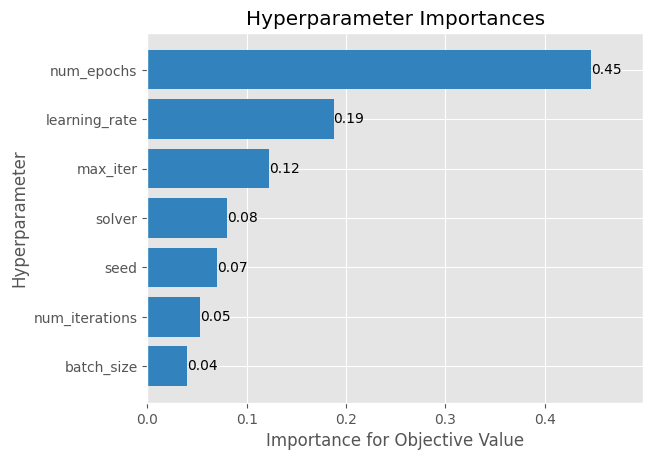

In [23]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(best_run.backend);

## Hypter paramter tuning for Multi-label Classification


In [17]:
def make_model(params=None):
    multi_target_strategy = params["multi_target_strategy"] if params else "one-vs-rest"
    
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(
        pretrained_model_name, multi_target_strategy=multi_target_strategy
    )

In [18]:
trainer = SetFitTrainer(
    model_init=make_model,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    metric= f1_score_weigted,
    loss_class=CosineSimilarityLoss,
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [19]:
def hyperparameter_search_function(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1e-1, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 5),
        "batch_size": trial.suggest_categorical("batch_size", [2, 4, 8, 16]),
        "multi_target_strategy": trial.suggest_categorical("multi_target_strategy", ["one-vs-rest", "multi-output", "classifier-chain"]),
        "seed": trial.suggest_int("seed", 1, 40),
        "num_iterations": trial.suggest_int("num_iterations", 1, 30),
        "max_iter": trial.suggest_int("max_iter", 100, 400),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }

In [ ]:
best = trainer.hyperparameter_search(hyperparameter_search_function,                                  
    compute_objective=lambda x: x, 
    study_name='SetFit optuna 2023 - 9 classes - multilabel',
    n_trials=10,
    storage='sqlite:///optuna.db',
    load_if_exists=True,)
best

[I 2023-07-27 11:05:41,350] Using an existing study with name 'SetFit optuna 2023 - 9 classes - multilabel' instead of creating a new one.
Trial: {'learning_rate': 0.0014031223152764776, 'num_epochs': 4, 'batch_size': 8, 'multi_target_strategy': 'classifier-chain', 'seed': 20, 'num_iterations': 11, 'max_iter': 271, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/11 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12045
  Num epochs = 4
  Total optimization steps = 6024
  Total train batch size = 8


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1506 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1506 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1506 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1506 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-27 11:17:34,808] Trial 7 finished with value: 0.7441860465116279 and parameters: {'learning_rate': 0.0014031223152764776, 'num_epochs': 4, 'batch_size': 8, 'multi_target_strategy': 'classifier-chain', 'seed': 20, 'num_iterations': 11, 'max_iter': 271, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7441860465116279.
Trial: {'learning_rate': 8.752064650935655e-06, 'num_epochs': 1, 'batch_size': 2, 'multi_target_strategy': 'classifier-chain', 'seed': 30, 'num_iterations': 17, 'max_iter': 160, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/17 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 18615
  Num epochs = 1
  Total optimization steps = 9308
  Total train batch size = 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/9308 [00:00<?, ?it/s]

***** Running evaluation *****
[I 2023-07-27 11:27:55,859] Trial 8 finished with value: 0.6802780412227034 and parameters: {'learning_rate': 8.752064650935655e-06, 'num_epochs': 1, 'batch_size': 2, 'multi_target_strategy': 'classifier-chain', 'seed': 30, 'num_iterations': 17, 'max_iter': 160, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7441860465116279.
Trial: {'learning_rate': 0.055691079577575894, 'num_epochs': 5, 'batch_size': 16, 'multi_target_strategy': 'classifier-chain', 'seed': 24, 'num_iterations': 18, 'max_iter': 159, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/18 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 19710
  Num epochs = 5
  Total optimization steps = 6160
  Total train batch size = 16


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1232 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1232 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1232 [00:00<?, ?it/s]

In [ ]:
selected_params = best.hyperparameters
selected_params

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(best.backend);

In [ ]:
trainer.apply_hyperparameters(best.hyperparameters, final_model=True) # replaces model_init with a fixed model
trainer.train()

In [ ]:
metrics = trainer.evaluate()
best.objective, metrics

In [41]:
volumes = np.arange(0.2, 1.2, 0.2)

In [47]:
a1 = [0.5407640088850539,
 0.5939150442621375,
 0.6024445497490347,
 0.6192299433317479,
 0.60253304088667]

a2 = [0.5337615890329364,
 0.5672770365109032,
 0.5856350931981184,
 0.5626532520976966,
 0.6267394682099666]

a3 = [0.4585845441400997,
 0.5127183222914486,
 0.5639762858220235,
 0.5926547318050585,
 0.6119047135472258]


a = [(a1[i]+a3[i]+a2[i])/3 for i in range(len(a1))]
a

[0.5110367140193633,
 0.5579701343548298,
 0.5840186429230588,
 0.591512642411501,
 0.6137257408812875]

In [48]:
percentages = [str(int(v*train_dev_df.shape[0])) for v in volumes]
percentages

['108', '216', '324', '432', '541']

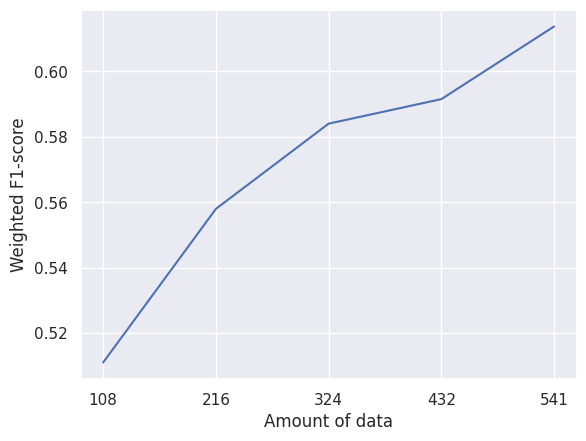

In [49]:
sns.set_theme(style="darkgrid")
ax = sns.lineplot(x=percentages, y=a)
ax.set(xlabel='Amount of data', ylabel='Weighted F1-score')
plt.show()